In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.datasets import load_breast_cancer
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [2]:
# Load the dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# Split the dataset into training and testing sets
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Save the training and testing sets to CSV files
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)


In [3]:
# Load the datasets from CSV files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Define predictors and target
predictors = [x for x in train.columns if x != 'target']
target = 'target'


In [4]:
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [5]:
predictors

['mean radius',
 'mean texture',
 'mean perimeter',
 'mean area',
 'mean smoothness',
 'mean compactness',
 'mean concavity',
 'mean concave points',
 'mean symmetry',
 'mean fractal dimension',
 'radius error',
 'texture error',
 'perimeter error',
 'area error',
 'smoothness error',
 'compactness error',
 'concavity error',
 'concave points error',
 'symmetry error',
 'fractal dimension error',
 'worst radius',
 'worst texture',
 'worst perimeter',
 'worst area',
 'worst smoothness',
 'worst compactness',
 'worst concavity',
 'worst concave points',
 'worst symmetry',
 'worst fractal dimension']

# Function explaination

1. Setting Up Variables

- predictors = [x for x in train.columns if x != 'target']
- target = 'target'

    - train and test: These are the DataFrames containing your training and testing datasets.
    - predictors: This is a list of column names from train, excluding the target column target. These columns will be used as features for the model.
    - target: This is the name of the target column, which contains the labels that the model will learn to predict.
 
2. Defining the modelfit Function

- def modelfit(alg, dtrain, dtest, predictors, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):

    - alg: This is the machine learning algorithm instance (in this case, an XGBoost classifier).
    - dtrain: This is the training dataset.
    - dtest: This is the testing dataset.
    - predictors: List of feature columns.
    - target: The target column name.
    - useTrainCV: Boolean flag to decide whether to use cross-validation.
    - cv_folds: Number of folds for cross-validation.
    - early_stopping_rounds: Number of rounds to use for early stopping during cross-validation.

3. Using Cross-Validation

- if useTrainCV:
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
    xgtest = xgb.DMatrix(dtest[predictors].values)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
        metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
    alg.set_params(n_estimators=cvresult.shape[0])

    - if useTrainCV:: Checks if cross-validation should be used.
    - xgb_param = alg.get_xgb_params(): Retrieves the parameters of the XGBoost model.
    - xgtrain and xgtest: Convert the training and testing data to DMatrix objects, which are optimized data structures for XGBoost.
    - cvresult: Performs cross-validation using the specified parameters and datasets.
        - num_boost_round: Maximum number of boosting rounds.
        - nfold: Number of folds in cross-validation.
        - metrics='auc': Evaluation metric used for validation (Area Under Curve).
        - early_stopping_rounds: Stops training if the model doesn't improve after a certain number of rounds.
        - verbose_eval=False: Suppresses output during cross-validation.
    - alg.set_params(n_estimators=cvresult.shape[0]): Sets the number of boosting rounds based on the result of cross-validation.

4. Fitting the Model

##### Fit the algorithm on the data
- alg.fit(dtrain[predictors], dtrain[target], eval_metric='auc')
     - alg.fit(): Trains the XGBoost model on the training data.
     - dtrain[predictors]: The feature columns of the training dataset.
     - dtrain[target]: The target column of the training dataset.
     - eval_metric='auc': Specifies the evaluation metric (AUC) to be used during training.

5. Making Predictions and Evaluating the Model

- dtrain_predictions = alg.predict(dtrain[predictors])
- dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

    - dtrain_predictions: Predicted labels for the training dataset.
    - dtrain_predprob: Predicted probabilities for the positive class (used for AUC calculation).

6. Printing Model Report

- print("\nModel Report")
- print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
- print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))

    - metrics.accuracy_score: Calculates the accuracy of the predictions.
    - metrics.roc_auc_score: Calculates the AUC score of the predicted probabilities.


7. Plotting Feature Importances

- feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
- feat_imp.plot(kind='bar', title='Feature Importances')
- plt.ylabel('Feature Importance Score')
- plt.show()

    - alg.get_booster().get_fscore(): Retrieves feature importance scores from the trained model.
    - pd.Series(...).sort_values(ascending=False): Converts the feature importance scores to a Pandas Series and sorts them in descending order.
    - feat_imp.plot(...): Plots the feature importance scores as a bar chart.
    - plt.show(): Displays the plot.

C:\Users\hp\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Model Report
Number of Boosted Trees (n_estimators): 181
Accuracy : 1
AUC Score (Train): 1.000000
AUC Score (Test): 0.991484


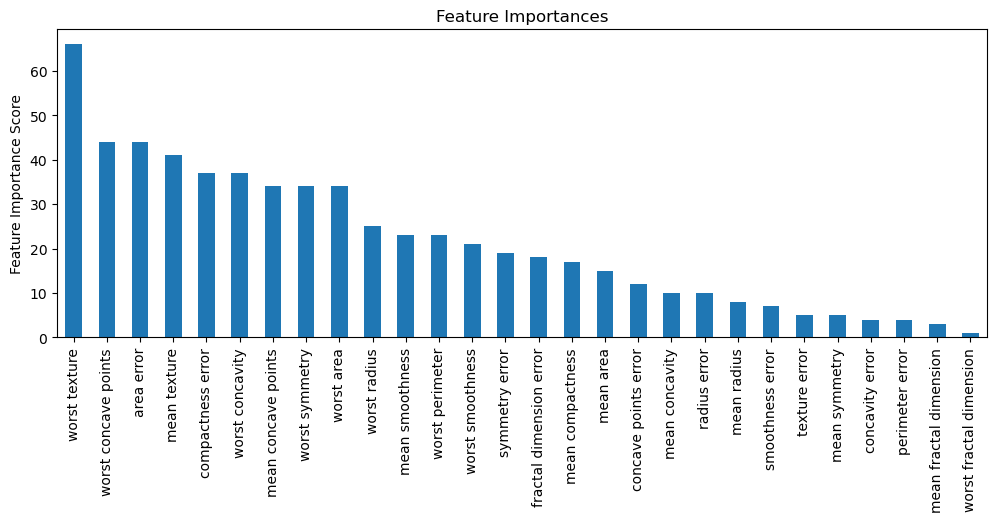

In [6]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

def modelfit(alg, dtrain, dtest, predictors, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    # Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target], eval_metric='auc')
        
    # Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    # Predict test set:
    dtest_predictions = alg.predict(dtest[predictors])
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
        
    # Print model report:
    print("\nModel Report")
    print("Number of Boosted Trees (n_estimators):", alg.get_params()['n_estimators'])
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
    print("AUC Score (Test): %f" % metrics.roc_auc_score(dtest[target], dtest_predprob))
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()

xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27
)

# Train the model using the loaded datasets
modelfit(xgb1, train, test, predictors, target)


In [7]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(train[predictors],train[target])

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=140,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             n_jobs=4,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             scoring='roc_auc')

In [8]:
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([0.38784447, 0.32680054, 0.30424662, 0.49585671, 0.34660821,
         0.29713101, 0.46784148, 0.34726839, 0.32597032, 0.48592739,
         0.38012757, 0.27625914]),
  'std_fit_time': array([0.01711149, 0.02369186, 0.04451997, 0.02238004, 0.02019047,
         0.02602548, 0.01762012, 0.02779354, 0.03026897, 0.02465985,
         0.01999557, 0.0616743 ]),
  'mean_score_time': array([0.02215776, 0.02417016, 0.02215018, 0.02015285, 0.02258167,
         0.02256532, 0.02014475, 0.02256627, 0.02055259, 0.0205698 ,
         0.0189527 , 0.02221179]),
  'std_score_time': array([4.01945644e-03, 4.93328301e-03, 3.11596105e-03, 1.65314705e-05,
         3.90496733e-03, 2.95709133e-03, 1.00015386e-05, 3.91260876e-03,
         8.10290512e-04, 8.03970399e-04, 3.49609500e-03, 4.06905978e-03]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, F

In [9]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test2 = {
    'max_depth':[4,5,6],
    'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2.fit(train[predictors],train[target])

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=2,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=140,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             n_jobs=4,
             param_grid={'max_depth': [4, 5, 6], 'min_child_weight': [4, 5, 6]},
             scoring='roc_auc')

In [10]:
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([0.35738354, 0.27814684, 0.26561165, 0.30426788, 0.32636085,
         0.29473019, 0.33131547, 0.2939013 , 0.26684909]),
  'std_fit_time': array([0.03040782, 0.01506113, 0.01957794, 0.01730432, 0.03300229,
         0.0156093 , 0.0188592 , 0.02523199, 0.04646708]),
  'mean_score_time': array([0.0205369 , 0.020539  , 0.02255054, 0.01975904, 0.03023047,
         0.02017174, 0.02420154, 0.02017798, 0.02256222]),
  'std_score_time': array([8.15273452e-04, 8.11123867e-04, 3.89802996e-03, 8.28378065e-04,
         9.55011040e-03, 2.10914082e-05, 4.94963421e-03, 4.96159546e-05,
         6.91382323e-03]),
  'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[4, 5, 6, 4, 5, 6, 4, 5, 6],
               mask=[False, False, False, False, False, False, False, 

In [11]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test2b = {
    'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=4,
                                        min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2b, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2b.fit(train[predictors],train[target])

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=2,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=140,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             n_jobs=4, param_grid={'min_child_weight': [6, 8, 10, 12]},
             scoring='roc_auc')

In [12]:
gsearch2b.cv_results_, gsearch2b.best_params_, gsearch2b.best_score_

({'mean_fit_time': array([0.2664227 , 0.2337245 , 0.21152954, 0.20958867]),
  'std_fit_time': array([0.02033491, 0.01042514, 0.00637183, 0.00401885]),
  'mean_score_time': array([0.01857905, 0.02055974, 0.02014275, 0.0221611 ]),
  'std_score_time': array([3.24874290e-03, 8.09944491e-04, 1.21601890e-05, 3.11245425e-03]),
  'param_min_child_weight': masked_array(data=[6, 8, 10, 12],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'min_child_weight': 6},
   {'min_child_weight': 8},
   {'min_child_weight': 10},
   {'min_child_weight': 12}],
  'split0_test_score': array([0.99947753, 0.9968652 , 0.99320794, 0.99164054]),
  'split1_test_score': array([0.96491228, 0.96336429, 0.95407637, 0.95252838]),
  'split2_test_score': array([0.99845201, 0.99896801, 0.99896801, 0.99845201]),
  'split3_test_score': array([0.99122807, 0.9878741 , 0.9876161 , 0.98529412]),
  'split4_test_score': array([0.99380805, 0.99122807, 0.99226006, 0

In [13]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
                                        min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(train[predictors],train[target])

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=6,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=140,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             n_jobs=4, param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             scoring='roc_auc')

In [14]:
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([0.306391  , 0.24823599, 0.24777737, 0.31661429, 0.23327532]),
  'std_fit_time': array([0.03030776, 0.01165632, 0.00806203, 0.02668534, 0.03767452]),
  'mean_score_time': array([0.02013345, 0.02054763, 0.02215395, 0.02217002, 0.02134171]),
  'std_score_time': array([6.18492903e-06, 8.08007339e-04, 4.03149253e-03, 4.25076660e-03,
         3.50192782e-03]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.99947753, 0.99947753, 0.99947753, 0.99947753, 0.99947753]),
  'split1_test_score': array([0.96491228, 0.96491228, 0.96491228, 0.96697626, 0.96697626]),
  'split2_test_score': array([0.99845201, 0.99896801, 0.99845201, 0.99896801, 0.99896801]),
  'split3_test_score': array([0.99122807, 0.99122807, 0.991228

C:\Users\hp\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Model Report
Number of Boosted Trees (n_estimators): 157
Accuracy : 0.9912
AUC Score (Train): 0.998572
AUC Score (Test): 0.991484


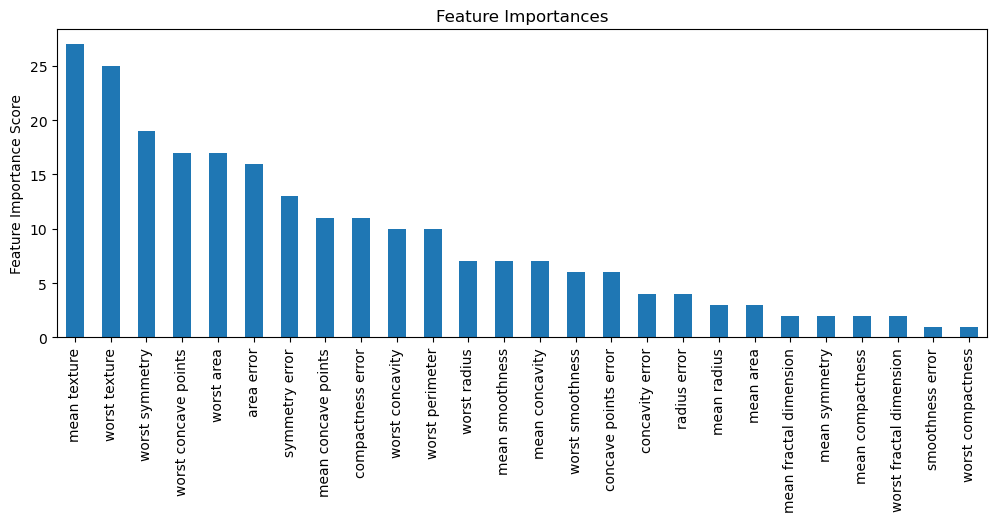

In [15]:
xgb2 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=4,
    min_child_weight=5,
    gamma=0.3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27
)

# Train the model using the loaded datasets
modelfit(xgb2, train, test, predictors, target)


In [16]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(train[predictors],train[target])

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=6,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=177,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             scoring='roc_auc')

In [17]:
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([0.32352414, 0.27196455, 0.29586768, 0.31278424, 0.2658886 ,
         0.27969813, 0.28573852, 0.29656982, 0.25989466, 0.2772922 ,
         0.29780455, 0.31559649, 0.29774728, 0.31488986, 0.29791508,
         0.297226  ]),
  'std_fit_time': array([0.03834536, 0.01280091, 0.01379144, 0.01455933, 0.01000874,
         0.01031614, 0.01353252, 0.01416834, 0.00403394, 0.00765187,
         0.0127132 , 0.00983863, 0.01708175, 0.01687068, 0.0116408 ,
         0.04459724]),
  'mean_score_time': array([0.02016683, 0.02055306, 0.02179294, 0.01817017, 0.01974807,
         0.01973772, 0.02014103, 0.02015209, 0.02017326, 0.02014041,
         0.01853633, 0.02014265, 0.0205555 , 0.01973553, 0.01857047,
         0.0201283 ]),
  'std_score_time': array([3.05746707e-05, 8.12836380e-04, 3.19401157e-03, 3.14031220e-03,
         8.26883653e-04, 8.08463248e-04, 1.20089145e-05, 1.87482523e-05,
         7.53255419e-05, 5.58937769e-06, 3.21841989e-03, 1.03646016e-05,
         8.21360123e-

In [18]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test5 = {
    'subsample':[i/100.0 for i in range(75,90,5)],
    'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test5, scoring='roc_auc',n_jobs=4, cv=5)
gsearch5.fit(train[predictors],train[target])

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=6,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=177,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.75, 0.8, 0.85],
                         'subsample': [0.75, 0.8, 0.85]},
             scoring='roc_auc')

In [19]:
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([0.2864181 , 0.29011779, 0.33423986, 0.30391388, 0.29866762,
         0.31219616, 0.30005546, 0.31604261, 0.39104819]),
  'std_fit_time': array([0.01209683, 0.01486246, 0.02180444, 0.01342372, 0.01323015,
         0.02296092, 0.01699469, 0.02705523, 0.06718684]),
  'mean_score_time': array([0.02255855, 0.02019877, 0.02578578, 0.02014909, 0.01853256,
         0.02055335, 0.02015362, 0.02261443, 0.0237721 ]),
  'std_score_time': array([2.96291636e-03, 6.16920040e-05, 7.35470506e-03, 2.84722498e-05,
         3.21689863e-03, 8.11753201e-04, 5.07435777e-03, 3.93886235e-03,
         4.51422488e-03]),
  'param_colsample_bytree': masked_array(data=[0.75, 0.75, 0.75, 0.8, 0.8, 0.8, 0.85, 0.85, 0.85],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array(data=[0.75, 0.8, 0.85, 0.75, 0.8, 0.85, 0.75, 0.8, 0.85],
               mask=[F

In [20]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test6 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test6, scoring='roc_auc',n_jobs=4, cv=5)
gsearch6.fit(train[predictors],train[target])

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.1,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=6,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=177,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             n_jobs=4, param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
             scoring='roc_auc')

In [21]:
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

({'mean_fit_time': array([0.3274559 , 0.33293376, 0.34140973, 0.35638299, 0.24917817]),
  'std_fit_time': array([0.0235901 , 0.04054645, 0.04552702, 0.01647483, 0.03538788]),
  'mean_score_time': array([0.02215004, 0.01853456, 0.02174997, 0.0201386 , 0.02012615]),
  'std_score_time': array([4.02833439e-03, 3.21916330e-03, 3.21139713e-03, 1.50075737e-05,
         1.78914995e-05]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'split0_test_score': array([0.99947753, 0.99947753, 0.99895507, 0.99947753, 0.5       ]),
  'split1_test_score': array([0.96439628, 0.96594427, 0.96542828, 0.96904025, 0.5       ]),
  'split2_test_score': array([0.99896801, 0.99845201, 0.99845201, 0.99793602, 0.5       ]),
  'split3_test_score': array([0.9907

In [22]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test7 = {
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test7, scoring='roc_auc',n_jobs=4, cv=5)
gsearch7.fit(train[predictors],train[target])

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.1,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=6,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=177,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             n_jobs=4, param_grid={'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]},
             scoring='roc_auc')

In [23]:
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

({'mean_fit_time': array([0.31175938, 0.30908847, 0.30948963, 0.30687041, 0.32896023]),
  'std_fit_time': array([0.01321867, 0.01698437, 0.01542016, 0.01461048, 0.06462052]),
  'mean_score_time': array([0.02013621, 0.02015576, 0.02013359, 0.02014227, 0.01975083]),
  'std_score_time': array([9.57790077e-06, 1.09543932e-05, 8.01398580e-06, 9.86649712e-06,
         5.20236524e-03]),
  'param_reg_alpha': masked_array(data=[0, 0.001, 0.005, 0.01, 0.05],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 0},
   {'reg_alpha': 0.001},
   {'reg_alpha': 0.005},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.05}],
  'split0_test_score': array([0.99947753, 0.99947753, 0.99947753, 0.99947753, 0.99947753]),
  'split1_test_score': array([0.96439628, 0.96439628, 0.96439628, 0.96594427, 0.96542828]),
  'split2_test_score': array([0.99896801, 0.99845201, 0.99896801, 0.99845201, 0.99845201]),
  'split3_test_score': array([

C:\Users\hp\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Model Report
Number of Boosted Trees (n_estimators): 98
Accuracy : 0.989
AUC Score (Train): 0.996090
AUC Score (Test): 0.996069


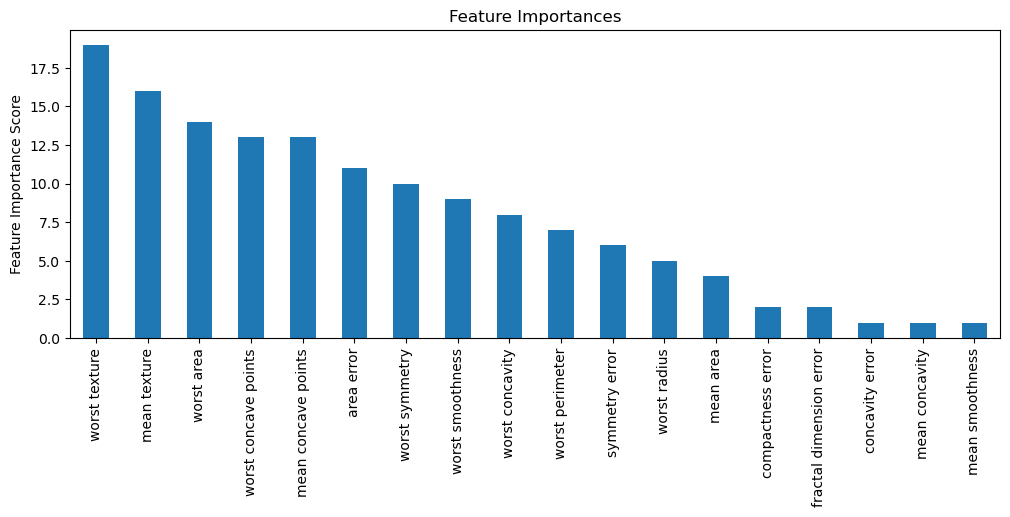

In [24]:
xgb3 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=4,
    min_child_weight=5,
    gamma=0.3,
    subsample=0.6,
    colsample_bytree=0.9,
    reg_alpha= 1,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27
)

# Train the model using the loaded datasets
modelfit(xgb3, train, test, predictors, target)


C:\Users\hp\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Model Report
Number of Boosted Trees (n_estimators): 443
Accuracy : 0.9846
AUC Score (Train): 0.995428
AUC Score (Test): 0.995742


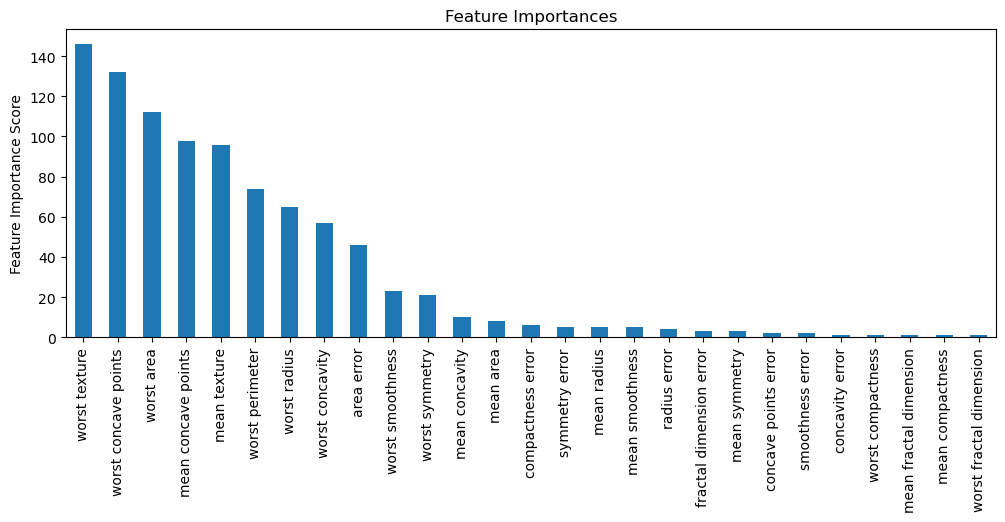

In [25]:
xgb4 = XGBClassifier(
    learning_rate =0.01,
    n_estimators=5000,
    max_depth=4,
    min_child_weight=5,
    gamma=0.3,
    subsample=0.6,
    colsample_bytree=0.9,
    reg_alpha= 1,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27
)

# Train the model using the loaded datasets
modelfit(xgb4, train, test, predictors, target)
